In [1]:
# ----------------------------------------------------------------------------
#
# TITLE - Lab3
# AUTHOR - James
# PROJECT - 2050
#
# Docstrings and metadata:
'''Lab 3 notebook
'''

__author__ = "James Lane"

In [95]:
### Imports

## Basic
import numpy as np
import sys, os, pdb
# import glob
# import subprocess

## Plotting
from matplotlib import pyplot as plt
# from matplotlib.backends.backend_pdf import PdfPages
# from matplotlib import colors
# from matplotlib import cm
# import aplpy

## Astropy
# from astropy.io import fits
# from astropy.coordinates import SkyCoord
# from astropy import table
# from astropy import units as apu
# from astropy import wcs

## galpy
# from galpy import orbit
# from galpy import potential
# from galpy.util import bovy_coords as gpcoords
# from galpy.util import bovy_conversion as gpconv
# from galpy.util import bovy_plot as gpplot

from scipy.optimize import newton

sys.path.append('../src/')
import ast2050.lab3

In [76]:
# Matplotlib for notebooks
%matplotlib notebook
%config InlineBackend.figure_format = 'retina'

# Make the dimensions of the horn

In [26]:
# Define constants
epsilon_ap = 0.51
a = 6.5 * 2.54 / 100 # meters
b = 4.0 * 2.54 / 100 # inches
max_d1 = 32 * 2.54 / 100 # maximum dimension
max_d2 = 40 * 2.54 / 100 # maximum dimension
wavelength = 21.106 / 100 # HI wavelength in meters

In [69]:
def gain_equation(A,a,b,wavelen,ep):
    
    
    return ( (4*np.pi)/(wavelen**2) ) * (ep*A/2) * (b+np.sqrt(b**2+(8*A*(A-a)/3)))
#def

def optimum_pyrimidal_horn(A,a,b,wavelen,ep):
    G = gain_equation(A,a,b,wavelen,ep)
    return (A**4)-(a*A**3)+(A*(3*b*G*wavelen**2/(8*np.pi*ep)))-(3*(G**2)*(wavelen**4)/(32*(np.pi**2)*(ep**2)))
#def

def calc_Rh(A,a,wavelen):
    return A*(A-a)/(3*wavelen)
#def

def calc_B(A,b):
    return 0.5*( b + np.sqrt( b**2 + 8*A*(A-a)/3 ) )
#def

def calc_R0H(Rh,A,a):
    return Rh*A/(A-a)
#def

def calc_R0E(Re,B,b):
    return Re*B/(B-b)
#def

def calc_alphaH(R0_H,A):
    return np.arctan((A/2)/R0_H)*180/np.pi
#def

def calc_alphaE(R0_E,B):
    return np.arctan((B/2)/R0_E)*180/np.pi
#def

In [70]:
A = 32*2.54/100 # In meters
R_H = calc_Rh(A,a,wavelength)
R_E = calc_Rh(A,a,wavelength)
B = calc_B(A,b)
G = gain_equation(A,a,b,wavelength,epsilon_ap)
R0_H = calc_R0H(R_H,A,a)
R0_E = calc_R0E(R_E,B,b)
alpha_H = calc_alphaH(R0_H,A)
alpha_E = calc_alphaE(R0_E,B)

In [77]:
A = 50*2.54/100 # In meters
R_H = calc_Rh(A,a,wavelength)
R_E = calc_Rh(A,a,wavelength)
B = calc_B(A,b)
G = gain_equation(A,a,b,wavelength,epsilon_ap)
R0_H = calc_R0H(R_H,A,a)
R0_E = calc_R0E(R_E,B,b)
alpha_H = calc_alphaH(R0_H,A)
alpha_E = calc_alphaE(R0_E,B)

print( 'A: '+str(A) )
print( 'B: '+str(B) )
print( 'R H: '+str(R_H) )
print( 'R E: '+str(R_E) )
print( 'R0 H: '+str(R0_H) )
print( 'R0 E: '+str(R0_E) )
print( 'G: '+str(R_H) )
print( 'Alpha H: '+str(alpha_H) )
print( 'Alpha E: '+str(alpha_E) )

A: 1.27
B: 1.019336339018831
R H: 2.216151805173884
R E: 2.216151805173884
R0 H: 2.5473009254872228
R0 E: 2.461495716962743
G: 2.216151805173884
Alpha H: 13.99759747002781
Alpha E: 11.698145498636139


# Calculate the RA/Dec of the galactic plane

In [106]:
import importlib
importlib.reload(ast2050.lab3)

ra, dec = ast2050.lab3.calculate_galactic_longitude_radec( np.linspace(0,360,num=10) )
alt, az = ast2050.lab3.calculate_galactic_longitude_altaz( np.linspace(0,360,num=10), '2018-3-20 17:00:00' )

In [107]:
alt

array([-28.34369774,   2.72282496,  33.19979222,  52.32022315,
        41.68017593,  13.13822299, -18.46575147, -45.44149287,
       -50.79770715, -28.34369774])

In [108]:
from astropy.time import Time
from astropy.coordinates import SkyCoord, EarthLocation, AltAz
from astropy import units as apu

In [125]:
coords = SkyCoord( ra=99.4279583*apu.deg, dec=16.3992778*apu.deg )
toronto_location = EarthLocation( lon=(360-79.3832)*apu.deg, lat=43.6532*apu.deg, 
                                      height=70*apu.m )
date_time_string = '2019-3-20 16:50:00'
utcoffset = -4*apu.hour # EDT
time = Time(date_time_string) - utcoffset
coord_altaz = coords.transform_to(AltAz(obstime=time, 
                                            location=toronto_location))

In [128]:
coord_altaz.alt

<Latitude 40.89707243 deg>

# Try and determine some power spectra

In [16]:
# Parameters of the fit
sample_rate = 5.0E6 # Samples per second. Could also be 20 MHz for March 20 data
local_oscillator_frequency = 1.420E9 # Frequency in hertz
bandpass = 5E6 # Could be 10 MHz for March 20 data

In [2]:
data_path = '/Users/JamesLane/Desktop/my_data.dat'
background_path = '/Users/JamesLane/Desktop/background.dat'

In [69]:
data = np.fromfile(data_path, dtype='int16')[:10000] - 2**11
background = np.fromfile(background_path, dtype='int16')[:10000] - 2**11

# Trim the background time series to match the length of the data time series
background = background[:len(data)]

In [70]:
# Take the fourier transform and shift it
ft_data = np.fft.fftshift(np.fft.fft( data ))
ft_background = np.fft.fftshift(np.fft.fft( background ))

In [71]:
# Determine the frequencies
freq_data = np.fft.fftshift( np.fft.fftfreq( len(data), 1/sample_rate ) )
freq_background = np.fft.fftshift( np.fft.fftfreq( len(data), 1/sample_rate ) )

We need to be aware that the output of the mixer are frequencies at:

$
f_{1} = f_{RF} + f_{LO}
$

and

$
f_{2} = f_{RF} - f_{LO}
$

So we are aiming to recover:

$
f_{RF} = |f_{RF} - f_{LO}| + f_{LO}
$


In [72]:
# Calculate the power using the periodogram
power_data = np.abs(ft_data)**2 + np.abs(ft_data[::-1])**2
power_background = np.abs(ft_background)**2 + np.abs(ft_background[::-1])**2

In [82]:
# Only take the positive frequencies:
n_data = len(data)
freq_data_rf = np.abs( freq_data[ :int(len(data)/2) ] ) + local_oscillator_frequency + bandpass/4
power_data_rf = power_data[ :int(len(data)/2) ] / n_data**2
power_background_rf = power_background[ :int(len(data)/2) ] / n_data**2

In [83]:
# Subtract the background and normalize the power
power_data_rf_bsub = ( power_data_rf - power_background_rf )

# Plot

<IPython.core.display.Javascript object>


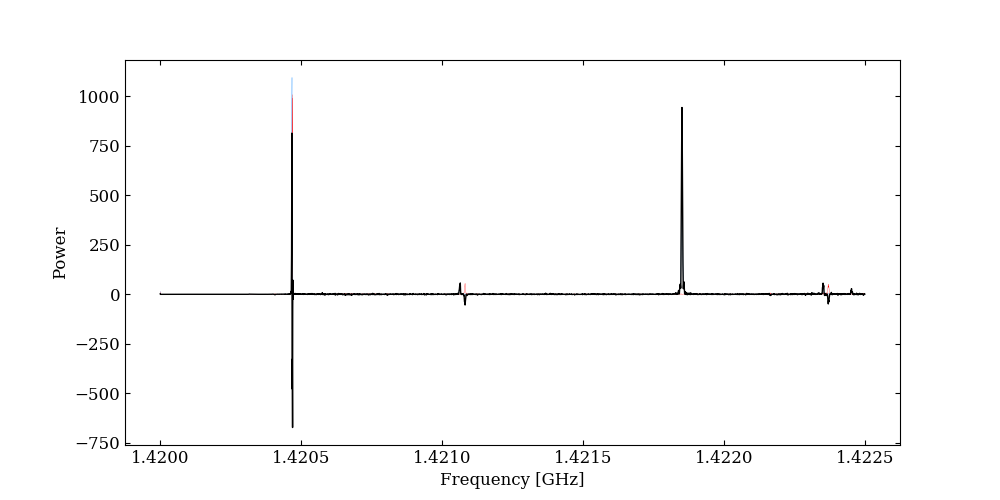

In [84]:
fig = plt.figure( figsize=(10,5) )
ax = fig.add_subplot(111)

ax.plot( freq_data_rf/1.0E9, power_data_rf, linewidth=0.2, color='DodgerBlue' )
ax.plot( freq_data_rf/1.0E9, power_background_rf, linewidth=0.2, color='Red' )
ax.plot( freq_data_rf/1.0E9, power_data_rf_bsub, linewidth=1.0, color='Black')

ax.set_xlabel('Frequency [GHz]')
ax.set_ylabel('Power')

plt.show()
pass;

# Try the sun

In [85]:
data_path = '/Users/JamesLane/Desktop/sun_on.dat'
background_path = '/Users/JamesLane/Desktop/sun_off.dat'

In [86]:
data = np.fromfile(data_path, dtype='int16')[:10000] - 2**11
background = np.fromfile(background_path, dtype='int16')[:10000] - 2**11

# Trim the background time series to match the length of the data time series
background = background[:len(data)]

In [87]:
# Take the fourier transform and shift it
ft_data = np.fft.fftshift(np.fft.fft( data ))
ft_background = np.fft.fftshift(np.fft.fft( background ))

In [88]:
# Determine the frequencies
freq_data = np.fft.fftshift( np.fft.fftfreq( len(data), 1/sample_rate ) )
freq_background = np.fft.fftshift( np.fft.fftfreq( len(data), 1/sample_rate ) )

In [89]:
# Calculate the power using the periodogram
power_data = np.abs(ft_data)**2 + np.abs(ft_data[::-1])**2
power_background = np.abs(ft_background)**2 + np.abs(ft_background[::-1])**2

In [90]:
# Only take the positive frequencies:
n_data = len(data)
freq_data_rf = np.abs( freq_data[ :int(len(data)/2) ] ) + local_oscillator_frequency
power_data_rf = power_data[ :int(len(data)/2) ] / n_data**2
power_background_rf = power_background[ :int(len(data)/2) ] / n_data**2

In [91]:
# Subtract the background and normalize the power
power_data_rf_bsub = ( power_data_rf - power_background_rf )

<IPython.core.display.Javascript object>


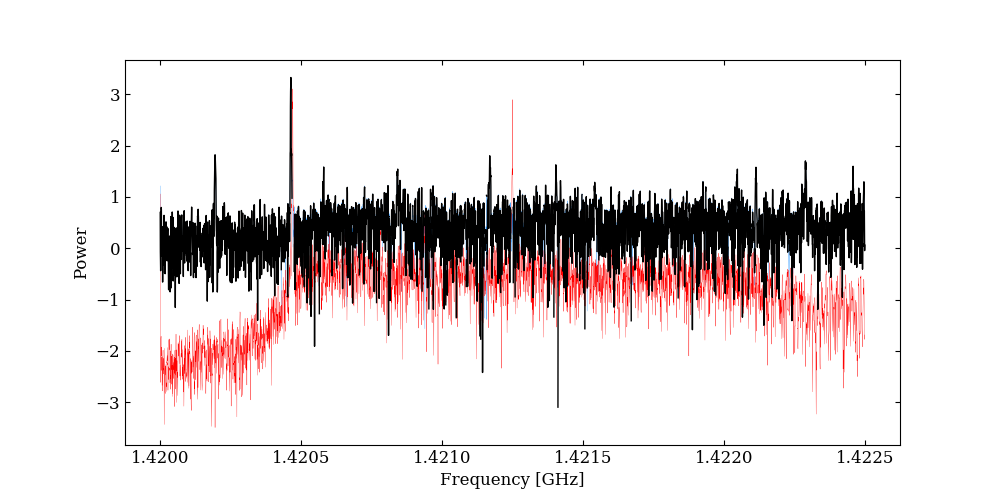

/Users/JamesLane/Software/Python/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log10
  


In [129]:
fig = plt.figure( figsize=(10,5) )
ax = fig.add_subplot(111)

ax.plot( freq_data_rf/1.0E9, np.log10(power_data_rf) , linewidth=0.2, color='DodgerBlue' )
ax.plot( freq_data_rf/1.0E9, np.log10(power_background_rf) , linewidth=0.2, color='Red' )
ax.plot( freq_data_rf/1.0E9, np.log10(power_data_rf_bsub) , linewidth=1.0, color='Black')

ax.set_xlabel('Frequency [GHz]')
ax.set_ylabel('Power')

plt.show()
pass;